# Fraud Detection

**As an initial trial, the model selected for this problem will be random forest algorithm. Tree based models proved to be a robust solution for tabular data.**



**All the features present will be used for model training except for the name of the sender and reciever accounts which are nearly unique for each example**

  
**Two new features will be added which are:**

**1- the difference between account balances before and after the transaction.**

**2- binary feature which determines if all the balance in the origin account was transferred within the transaction or not.**
       
       
**Data will be split so that 20% of the data used for validation keeping the ratio of minor class the same in both train and test sets.**
 

**For better testing, macro precision, recal and f1-score will be used as metrics. The accuracy of minor class will be measured separately as well.**

In [1]:
##IMPORTING RELEVANT LIBRARIES
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import pickle

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
#Define global variables
scaled_columns = ["amount", "oldbalanceOrig", "newbalanceOrig","oldbalanceDest", "newbalanceDest"]

final_cols_order = ["amount","oldbalanceOrig","newbalanceOrig","oldbalanceDest","newbalanceDest", 
                    "orig_diff", "dest_diff", "step", "type", "balance_equals_amount", "isFraud"]

transaction_type_dict = {"PAYMENT":0,
                        "TRANSFER":1,
                        "CASH_OUT":2,
                        "DEBIT":3,
                        "CASH_IN":4}

inverse_label_dict = {0:"Not_Fraud",
                      1:"Fraud"}


scaler = StandardScaler()

In [3]:
##Reading Data
data = pd.read_csv("./Data/transactions_train.csv")

In [4]:
##helper functions for feature engineering
def get_balance_diff(old_balance, new_balance):
    return new_balance-old_balance

def balance_equals_amount(old_balance, amount):
    return (old_balance==amount) *1
    

def add_features(df):
    df_new = df.copy()
    df_new["type"] = df_new["type"].map(lambda x:transaction_type_dict[x])
    
    scaler.fit(df_new[scaled_columns].values.reshape(-1, 1))
    
    for col in scaled_columns:
        df_new[col] = scaler.transform(df_new[col].values.reshape(-1, 1));

    df_new["orig_diff"] = df_new.apply(lambda x: get_balance_diff(x.oldbalanceOrig,
                                                                  x.newbalanceOrig), axis=1)
    df_new["dest_diff"] = df_new.apply(lambda x: get_balance_diff(x.oldbalanceDest,
                                                                  x.newbalanceDest), axis=1)
    df_new["balance_equals_amount"] = df_new.apply(lambda x: balance_equals_amount(x.oldbalanceOrig,
                                                                                   x.amount), axis=1)
    
    df_new.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)
    
    df_new = df_new[final_cols_order]
    return df_new

In [5]:
#add new features and display new dataframe
data_new = add_features(data)
display(data_new)

,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,orig_diff,dest_diff,step,type,balance_equals_amount,isFraud
0,-0.282944,-0.228273,-0.231629,-0.286300,-0.286300,-0.003356,0.000000,1,0,0,0
1,-0.285664,-0.279052,-0.279688,-0.286300,-0.286300,-0.000636,0.000000,1,0,0,0
2,-0.286238,-0.286238,-0.286300,-0.286300,-0.286300,-0.000062,0.000000,1,1,1,1
3,-0.286238,-0.286238,-0.286300,-0.279075,-0.286300,-0.000062,-0.007224,1,2,1,1
4,-0.282320,-0.272127,-0.276107,-0.286300,-0.286300,-0.003980,0.000000,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6351188,-0.230936,-0.230936,-0.286300,-0.286300,-0.286300,-0.055363,0.000000,699,1,1,1
6351189,-0.230936,-0.230936,-0.286300,-0.286300,-0.230936,-0.055363,0.055363,699,2,1,1
6351190,0.656187,0.656187,-0.286300,-0.286300,-0.286300,-0.942486,0.000000,699,1,1,1
6351191,0.656187,0.656187,-0.286300,-0.170504,0.771982,-0.942486,0.942486,699,2,1,1


In [6]:
##Splitting Data
data, label = data_new.iloc[:,:-1], data_new.iloc[:,-1]

X_train,X_cv,y_train,y_cv = train_test_split(data,label,test_size = 0.2, stratify = label)

In [7]:
##Training Random Forest Classifier
clf = RandomForestClassifier(random_state=0, n_estimators = 20)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20, random_state=0)

In [8]:
##Display Training Accuracy
y_pred = clf.predict(X_train)
print(f"Total Training Accuracy: {accuracy_score(y_train,y_pred)}")
print(f"Minor Classes Training Accuracy: {accuracy_score(y_train[y_train==1],y_pred[y_train==1])}")

Total Training Accuracy: 0.9999990159328347
Minor Classes Training Accuracy: 0.9991901522513768


In [9]:
##Display Validation Accuracy
y_pred = clf.predict(X_cv)
print(f"Total Validation Accuracy: {accuracy_score(y_cv,y_pred)}")
print(f"Minor Classes Validation Accuracy: {accuracy_score(y_cv[y_cv==1],y_pred[y_cv==1])}")

Total Validation Accuracy: 0.9999937019726209
Minor Classes Validation Accuracy: 0.9948152948801037


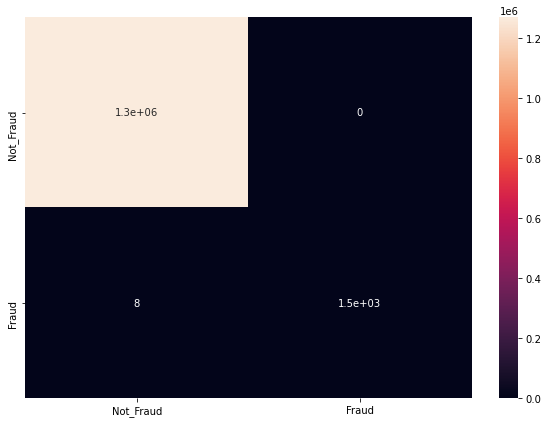

In [10]:
##Confusion Matrix
array = confusion_matrix(y_cv,y_pred)
df_cm = pd.DataFrame(array, index = [inverse_label_dict[i] for i in range(len(inverse_label_dict))],
                  columns = [inverse_label_dict[i] for i in range(len(inverse_label_dict))])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True);

In [11]:
##Display the classification report
print(classification_report(y_cv, y_pred, target_names=["Not Fraud", "Fraud"]))

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00   1268696
       Fraud       1.00      0.99      1.00      1543

    accuracy                           1.00   1270239
   macro avg       1.00      1.00      1.00   1270239
weighted avg       1.00      1.00      1.00   1270239



**Random forest performed perfectly on the dataset with almost 100% accuracy.**

**Scaler and classifier will be saved as pickle files to be used in model deployment**

In [12]:
#saving scaler and classifier
with open('scaler.pickle', 'wb') as f:
    pickle.dump(scaler, f)

with open('classifier.pickle', 'wb') as f:
    pickle.dump(clf, f)